In [7]:
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from sklearn.impute import SimpleImputer

In [8]:
def load_crime_data(df):
    dt = pd.read_csv(df,delim_whitespace = False,header=None)
    dt = dt.replace("?",np.NAN)
    dt = dt.values
    train_data = dt[:1500,5:127].astype("float")
    test_data = dt[1500:,5:127].astype("float")
    train_labels = dt[:1500,127:128].astype("float")
    test_labels = dt[1500:,127:128].astype("float")
    return (train_data,train_labels),(test_data,test_labels)

In [9]:
(train_data,train_labels),(test_data,test_labels) = load_crime_data("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data")

In [10]:
imp = SimpleImputer(missing_values=np.NAN, strategy='mean')
train_data = imp.fit_transform(train_data)
test_data = imp.fit_transform(test_data)
train_labels = imp.fit_transform(train_labels)
test_labels = imp.fit_transform(test_labels)
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(1500, 122)
(494, 122)
(1500, 1)
(494, 1)


In [11]:
train_data

array([[0.19      , 0.33      , 0.02      , ..., 0.5       , 0.32      ,
        0.14      ],
       [0.        , 0.16      , 0.12      , ..., 0.45188285, 0.        ,
        0.19075314],
       [0.        , 0.42      , 0.49      , ..., 0.45188285, 0.        ,
        0.19075314],
       ...,
       [0.        , 0.52      , 0.04      , ..., 0.45188285, 0.        ,
        0.19075314],
       [0.04      , 0.51      , 0.07      , ..., 0.45188285, 0.        ,
        0.19075314],
       [0.03      , 0.59      , 0.2       , ..., 0.45188285, 0.        ,
        0.19075314]])

In [12]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [13]:
# Training and validation of the model
k = 4
num_val_sample = len(train_data)//k
num_epochs = 500
all_scores = []
all_mae_histories = []

# k-fold cross validation
for i in range(k):
    print('processing fold #',i)
    
    # prepare validation fold
    val_data = train_data[i * num_val_sample: (i+1) * num_val_sample]
    val_labels = train_labels[i * num_val_sample: (i+1) * num_val_sample]
    
    # concentrate training fold
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_sample],
         train_data[(i+1) * num_val_sample:]],
        axis = 0)
    partial_train_labels = np.concatenate(
        [train_labels[:i*num_val_sample],
         train_labels[(i+1)*num_val_sample:]],
        axis=0)
    # train using the training fold
    model = build_model() # create a compiled model using our function
    history = model.fit(
    partial_train_data,partial_train_labels,
    epochs=num_epochs,batch_size=32,verbose=0) # silent mode (verbose=0)
    test_mse_score,test_mae_score = model.evaluate(val_data,val_labels)
    print(test_mae_score)
    # record training performance
    history_dict = history.history
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)
    
    # record validation set performace per fold
    val_mse,val_mae = model.evaluate(val_data,val_labels,verbose=0)
    all_scores.append(val_mae)
    
    # END OF LOOP

# Compute average per-epoch MAE score for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
375/375 [==============================] - 0s 40us/step
0.10894224047660828
processing fold # 1
375/375 [==============================] - 0s 37us/step
0.12997408211231232
processing fold # 2
375/375 [==============================] - 0s 42us/step
0.11156613379716873
processing fold # 3
375/375 [==============================] - 0s 40us/step
0.09851018339395523


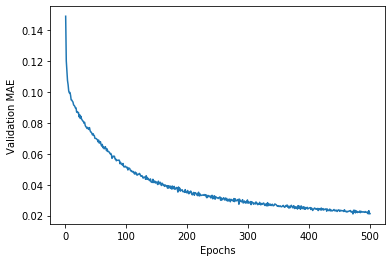

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

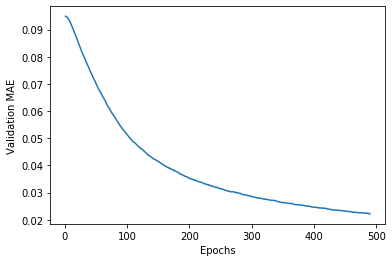

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [20]:
# Tune the model hyper paramters and retrain
model = build_model()

# Train on the entire dataset
model.fit(train_data,train_labels,epochs = 20,batch_size = 16,verbose = 1)

# Evaluate performace
test_mse_score,test_mae_score = model.evaluate(test_data,test_labels)

Epoch 1/20
1500/1500 [==============================] - 0s 79us/step - loss: 0.0394 - mae: 0.1428
Epoch 2/20
1500/1500 [==============================] - 0s 48us/step - loss: 0.0250 - mae: 0.1138
Epoch 3/20
1500/1500 [==============================] - 0s 47us/step - loss: 0.0223 - mae: 0.1059
Epoch 4/20
1500/1500 [==============================] - 0s 47us/step - loss: 0.0217 - mae: 0.1045
Epoch 5/20
1500/1500 [==============================] - 0s 50us/step - loss: 0.0202 - mae: 0.1014
Epoch 6/20
1500/1500 [==============================] - 0s 49us/step - loss: 0.0202 - mae: 0.0987
Epoch 7/20
1500/1500 [==============================] - 0s 49us/step - loss: 0.0195 - mae: 0.0990
Epoch 8/20
1500/1500 [==============================] - 0s 48us/step - loss: 0.0189 - mae: 0.0948
Epoch 9/20
1500/1500 [==============================] - 0s 50us/step - loss: 0.0190 - mae: 0.0967
Epoch 10/20
1500/1500 [==============================] - 0s 49us/step - loss: 0.0184 - mae: 0.0953
Epoch 11/20
1500/15

In [21]:
# Display the testing score
test_mae_score

0.09149861335754395

In [23]:
# Save the model details
model.save('crime_classify.hdf5')